In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template, peak_local_max
import seaborn as sns; sns.set()

In [67]:
filename = '../images/jensa_images/JENSA_4_5_bestTune_1pm_lighton.tiff'
img = cv2.imread(filename,0)

nobeam = '../images/jensa_images/JENSA_2_22_14_28_light_on.PNG'
img_nobeam= cv2.imread(nobeam, 0)

beam = '../images/jensa_images/JENSA_4_5_bestTune_1pm.PNG'
beam_img = cv2.imread(beam, 0)

bg_file=  '../images/jensa_images/bg_3_36.PNG'
bg = cv2.imread(bg_file, 0)

- 2xsqrt(2) is the extension we see at 45 degrees. so dividde by sqrt(2) for TRUE length in X-AXIS

- adopt 2 mm = 28 pixels based on these images. so vertical lines and horizontal lines are 28 px apart
CHECK THIS!

- look into affine transformation if viewer isnt parallel to camera https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/affine_image.html#sphx-glr-gallery-images-contours-and-fields-affine-image-py


In [61]:
miny=212
maxy=303
minx=222
maxx=320

#center_viewer=[ (maxx-minx)/2,(maxy-miny)/2]
crop_img = img[miny:maxy, minx:maxx].copy()
#print(center_viewer)

manual_center= [44,50]
#distances, up:42, down: 43, left:50, right:105-50= 55


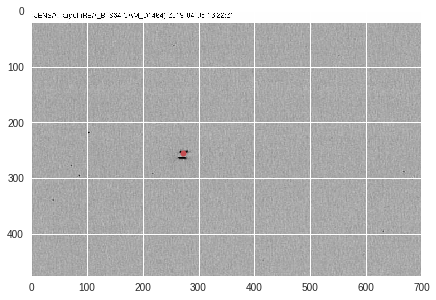

In [65]:
fig=plt.figure(figsize=(7,7))
plt.imshow(beam_img)
plt.plot(manual_center[1]+minx, 
    manual_center[0]+miny, 
    'o', 
    markeredgecolor='r',
    markerfacecolor='r', 
    markersize=6
    )

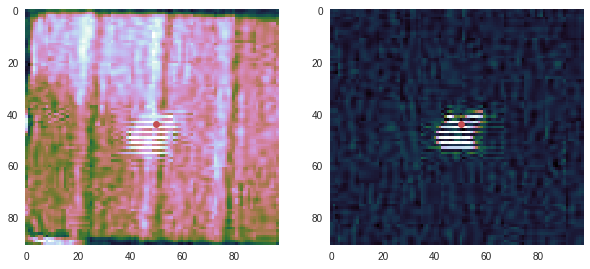

In [75]:
fig=plt.figure(figsize=(10,10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

crop_beam = beam_img[miny:maxy, minx:maxx].copy()


ax1.imshow(crop_img, cmap='cubehelix')
ax1.grid(False)
ax1.plot(manual_center[1], 
    manual_center[0], 
    'o', 
    markeredgecolor='none',
    markerfacecolor='r', 
    markersize=7
    )


ax2.imshow(crop_beam,cmap='cubehelix')
ax2.grid(False)
ax2.plot(manual_center[1], 
    manual_center[0], 
    'o', 
    markeredgecolor='none',
    markerfacecolor='r', 
    markersize=7
    )

#plt.savefig('JENSAcropped.png', dpi=300)


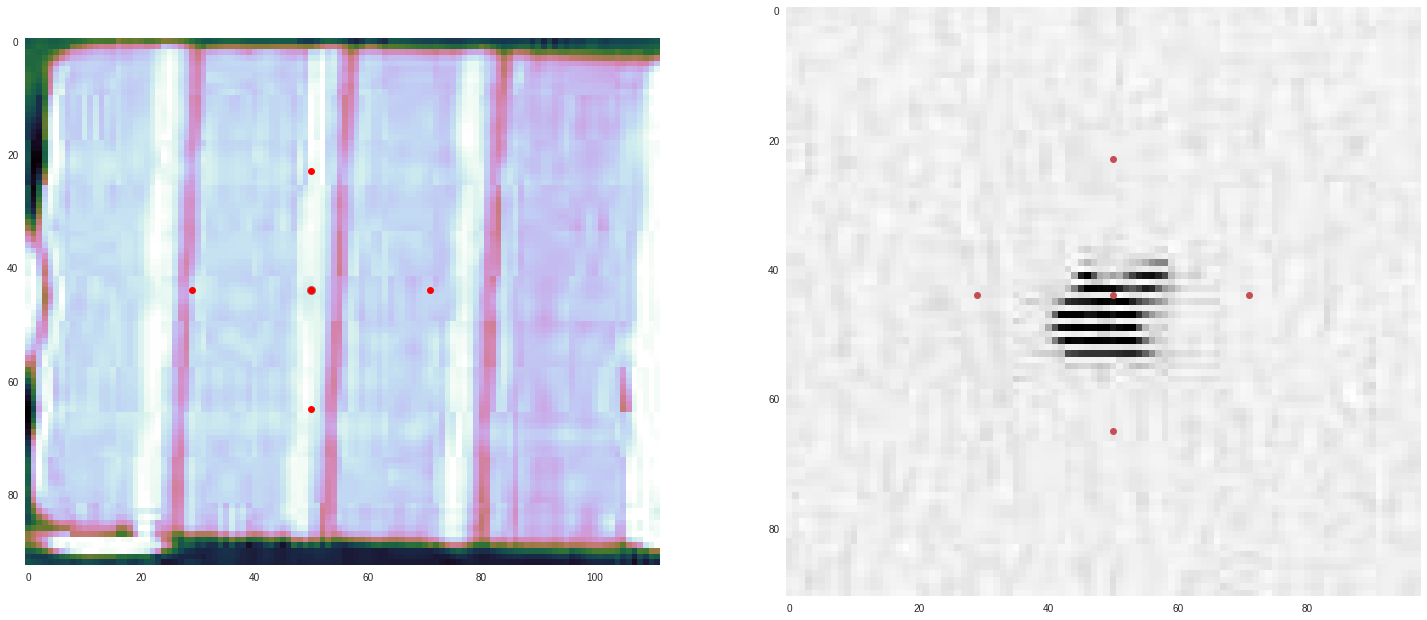

In [90]:
fig=plt.figure(figsize=(25,25))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(crop_nobeam, cmap="cubehelix")
ax1.grid(False)
ax1.plot(manual_center[1], 
    manual_center[0], 
    'o', 
    markeredgecolor='r',
    markerfacecolor='r', 
    markersize=9
    )
ax1.plot([50, (50+21), (50-21), 50, 50],[44, 44, 44, 44-21, 44+21],
            'o', markeredgecolor='red', markerfacecolor='red', markersize=7
			)

#ax1.plot([50, 50+21, 50-21, 50, 50],[44, 44, 44, 44-21, 44+21],
#            'o', markeredgecolor='red', markerfacecolor='blue', markersize=6
#			)

ax2.imshow(crop_beam)
ax2.grid(False)
ax2.plot([50, (50+21), (50-21), 50, 50],[44, 44, 44, 44-21, 44+21], 
    'o', 
    markeredgecolor='r',
    markerfacecolor='r', 
    markersize=7
        )

plt.savefig('JENSAcropped.png', dpi=300)

In [68]:
class Image:    
    def __init__(self, image):
        self.raw = image
        self.shape= image.shape
        self.x_size= image.shape[1]
        self.y_size= image.shape[0]
        self.subtracted_data= np.array([[0 for x in range(self.x_size)] for y in range(self.y_size)])
        self.profile_x= [0 in range (self.x_size)]
        self.profile_y= [0 in range (self.y_size)]
        self.offset_x= 0 
        self.offset_y= 0

    def subtract_bg(self,bg):
        print("Subtracting background...")
        if (bg.shape == self.shape): 
            for i in range(self.y_size):
                for j in range (self.x_size):
                    if ((self.raw[i][j]>bg[i][j]).all() and (bg[i][j]>=0).all() and (self.raw[i][j]>=0).all()):
                        self.subtracted_data[i][j]= self.raw[i][j]-bg[i][j]
                    elif (bg[i][j]<0):
                        self.subtracted_data[i][j]= 0
            return self.subtracted_data
        else:
            print("Error: Background image size :",bg.shape," does not match data size ",self.shape,".")
            
    def get_profile(self):
        print("Getting y-axis profile...")
        #PROFILE IN Y
        for i in range(self.y_size): #loop over all y
            sum=0
            for j in range(self.x_size): #loop over all x for each y: gives one number
                sum=sum + self.subtracted_data[i][j]
            self.profile_y.append(sum)
        self.offset_y= np.mean(self.profile_y[50:150])
        self.profile_y=self.profile_y[1:]- self.offset_y      
     
        #PROFILE IN X
        print("Getting x-axis profile...")
        for i in range(self.x_size): #loop over all x
            sum=0
            for j in range(self.y_size): #loop over all y for each x: gives one number
                sum=sum + self.subtracted_data[j][i]
            self.profile_x.append(sum)
        self.offset_x=np.mean(self.profile_x[1:150])
        self.profile_x=self.profile_x[1:]-self.offset_x

def findMedian(profile):
    sum_total=sum(profile)
    median=0
    sigp=0
    sign=0
    for i in range(len(profile)):
        sumInt=sum(profile[0:i])
        frac=sumInt/sum_total
        if (frac>0.15 and frac<0.17):
            sign=i
        elif (frac>0.48 and frac<0.52):
            median=i
        elif (frac>0.45 and frac<0.54):
            median=i
        elif (frac>0.41 and frac<0.58):
            median=i
        elif (frac>0.83 and frac<0.85):
            sigp=i
    if (median==0):
        print("Error when finding median. Check im_reduction ln 62.")
    return  median, sigp, sign

In [70]:
analyzedim=beam_img[miny:maxy, minx:maxx]
bg=bg[miny:maxy, minx:maxx]

In [71]:
image=Image(analyzedim)
image.subtract_bg(bg)
image.get_profile()

Subtracting background...
Getting y-axis profile...
Getting x-axis profile...


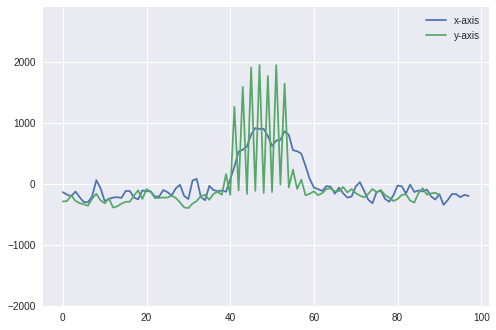

In [72]:
plt.plot(image.profile_x, label="x-axis")
plt.plot(image.profile_y, label="y-axis")
plt.ylim(-2000,2900)
plt.legend()

No handles with labels found to put in legend.


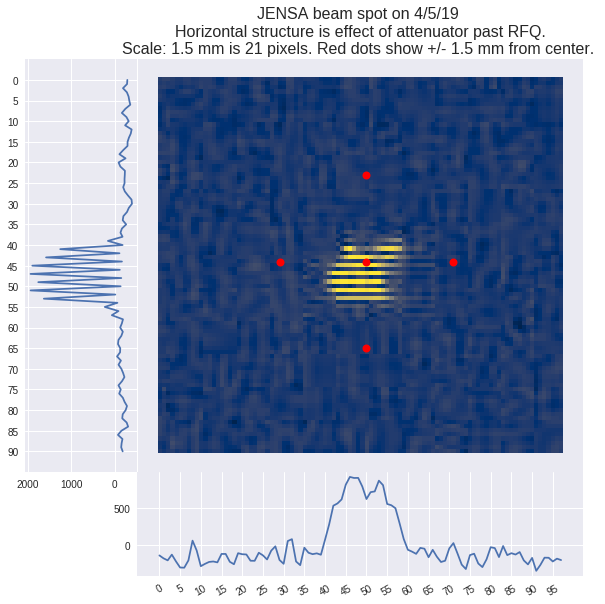

In [53]:
import matplotlib as mpl
#### plot and save results ####
y = np.arange(image.y_size)
x = np.arange(image.x_size)

mpl.style.use('seaborn')
fig = plt.figure(figsize=(14, 9.5))
grid = plt.GridSpec(5, 7, hspace=0, wspace=0)
main_ax = fig.add_subplot(grid[:-1, 1:])


#main_ax.get_xaxis().set_visible(False)
plt.setp(main_ax.get_xticklabels(), fontsize=16)
plt.setp(main_ax.get_yticklabels(), fontsize=16)

#Adding subplots for the profiles
y_hist = fig.add_subplot(grid[:-1, 1], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 2:6], sharex=main_ax)

#Plot the reduced image in center 
im=main_ax.imshow(analyzedim,  cmap='cividis')
#cax = fig.add_axes([04.27, 0.8, 4.5, 0.05])
#fig.colorbar(im, cax=cax, orientation='vertical')
main_ax.grid(False)


main_ax.set_title(
	"JENSA beam spot on 4/5/19 \n"+"Horizontal structure is effect of attenuator past RFQ." + 
	"\nScale: 1.5 mm is 21 pixels. Red dots show +/- 1.5 mm from center. " 
	,
	fontsize=16
	)

##Plotting dots. Their location is relative to to selected region of the light_image
main_ax.plot([50, 50+21, 50-21, 50, 50],[44, 44, 44, 44-21, 44+21],
            'o', markeredgecolor='red', markerfacecolor='red', markersize=8
			)

# plot the x and y profiles
#orange=(200/255,82/255,0/255)
x_hist.plot(x, image.profile_x)
x_hist.legend(loc="upper right", prop={'size':8})
xticks=[i for i in range(analyzedim.shape[1]) if i%5==0]
x_hist.set_xticks(xticks)
plt.xticks(rotation=30)
#x_hist.set_xticklabels(xticks, fontsize=12)
#x_hist.set_yticklabels(fontsize=12)

y_hist.plot(image.profile_y, y)
yticks= [i for i in range(analyzedim.shape[0]) if i%5==0]
y_hist.set_yticks(yticks)
#y_hist.set_yticklabels(yticks, fontsize=12)
#y_hist.set_yticklabels(fontsize=12)
y_hist.invert_xaxis()

plt.savefig('JENSAspot.png', dpi=300)

In [18]:
#miny=212
#maxy=303
#minx=222
#maxx=320

#center=[44, 50]
#now we have 
#21 pixels is 1.5 mm